# Get Data and data split

In [27]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

data = pd.read_csv('Data/train_cluster.csv')
data.drop('Unnamed: 0', inplace=True, axis=1)

np.random.seed(42)
idx = np.random.choice(range(len(data)),int(10e3) , replace=False)
smaller_data = data.iloc[idx]

X,y = smaller_data.drop('diagnosed_diabetes', axis=1), smaller_data['diagnosed_diabetes']

x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

x_train

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,cholesterol_total,family_history_diabetes,gender_Female,ethnicity_Asian,education_level_Graduate,income_level_Low,smoking_status_Current,employment_status_Employed
354456,43,1,83,6.5,7.1,179,0,1,0,1,0,0,1
558155,57,1,151,5.5,6.3,214,1,1,0,0,0,0,0
126279,49,3,49,6.9,5.2,162,0,1,0,1,0,0,0
126763,57,1,38,9.9,7.2,183,0,1,1,1,0,1,1
221837,50,1,47,3.5,6.3,200,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260506,51,5,393,6.2,6.6,175,0,1,0,1,0,0,1
141412,47,2,84,4.4,6.3,169,0,1,0,1,0,0,0
44799,73,1,65,4.2,7.4,195,0,1,0,0,0,0,1
243294,28,3,71,7.5,7.4,187,0,1,0,0,0,0,1


# Metric function

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2664
         1.0       1.00      1.00      1.00      4336

    accuracy                           1.00      7000
   macro avg       1.00      1.00      1.00      7000
weighted avg       1.00      1.00      1.00      7000



{'accuracy': 1.0, 'roc_score': 1.0}

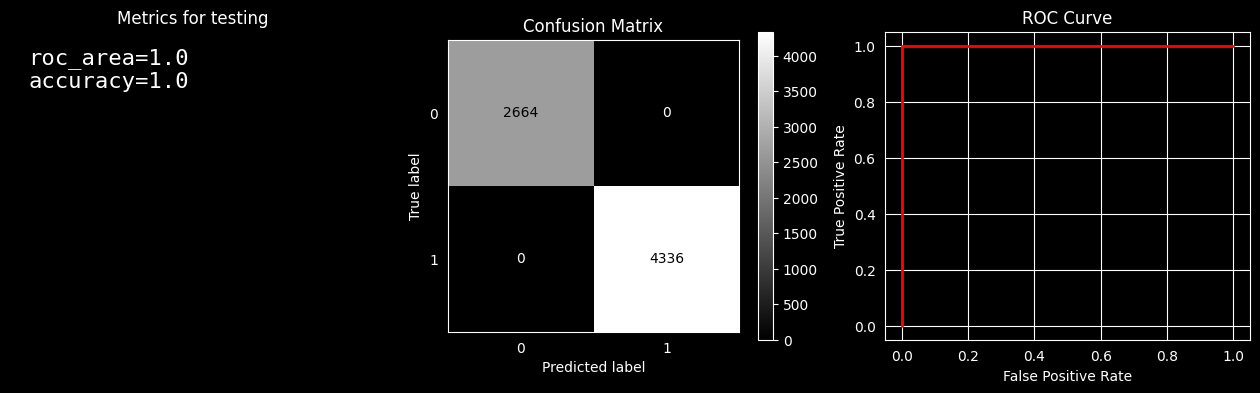

In [23]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, \
    roc_curve, classification_report


def metrics(preds:np.ndarray, probs:np.ndarray, lables:np.ndarray, method:str):
    cf_mtx = confusion_matrix(lables, preds)
    fpr, tpr, thresholds = roc_curve(lables, probs)
    roc_area = roc_auc_score(lables, probs)
    accuracy = accuracy_score(lables, preds)

    print(classification_report(lables, preds))

    text = f"{roc_area=}\n{accuracy=}"

    cf_mtx_disp = ConfusionMatrixDisplay(confusion_matrix=cf_mtx)
    roc_disp = RocCurveDisplay(fpr=fpr,tpr=tpr)

    fig, (ax_report, ax_matrix, ax_roc) = plt.subplots(1, 3, figsize=(16, 4))
    ax_report.text(
        x=0.05,
        y=0.95,
        s=text,
        family='monospace',
        fontsize=16,
        verticalalignment='top',
        transform=ax_report.transAxes)
    ax_report.set_title(f'Metrics for {method}')
    ax_report.axis('off')

    ax_matrix.set_title("Confusion Matrix")
    ax_matrix.grid(False)
    ax_matrix = cf_mtx_disp.plot(ax=ax_matrix, cmap='grey')

    ax_roc.set_title('ROC Curve')
    ax_roc.plot(fpr,tpr, linewidth=2, label='ROC Curve', color='red')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')


    return {"accuracy": accuracy, "roc_score": roc_area}


metrics(y_train,y_train,y_train, "testing")

# Optim Test Function

In [24]:
import optuna
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
import time

def selected_features(selector):
    mask = selector.get_support()
    selected_names = x_train.columns[mask]
    return list(selected_names)

def optimize_train_and_judge(title, model_class, objective_fn, trials=100):
    global x_train, y_train, x_test, y_test

    study = optuna.create_study(direction="maximize")

    start = time.time()
    study.optimize(objective_fn, n_trials=trials, show_progress_bar=True)
    stop = time.time()


    pipe = Pipeline([('features_selector', SelectKBest()) ,('classifier', model_class())])
    pipe.set_params(**study.best_params)
    pipe.fit(x_train, y_train)

    ## Metrics
    preds = pipe.predict(x_test)
    probs = pipe.predict_proba(x_test)[:, 1]
    metrics(preds, probs, y_test, title)

    selector = pipe.named_steps['features_selector']
    names_selected = selected_features(selector)
    features_shape = [x_test.shape[0], len(names_selected)]
    print(f"Selected features: {names_selected}")
    print(f"Optimize time: {stop-start}")

    return pipe

# Logistic Regression

[I 2025-12-25 21:57:11,203] A new study created in memory with name: no-name-21bc8acb-d0c1-4c81-8ead-d59fa34676c9


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-12-25 21:57:11,545] Trial 0 finished with value: 0.6747341829104765 and parameters: {'features_selector__k': 9, 'classifier__C': 0.05552488099188666, 'classifier__solver': 'liblinear'}. Best is trial 0 with value: 0.6747341829104765.
[I 2025-12-25 21:57:11,710] Trial 1 finished with value: 0.5724736662478466 and parameters: {'features_selector__k': 1, 'classifier__C': 11.41318955017202, 'classifier__solver': 'lbfgs'}. Best is trial 0 with value: 0.6747341829104765.
[I 2025-12-25 21:57:11,910] Trial 2 finished with value: 0.6465128253052452 and parameters: {'features_selector__k': 2, 'classifier__C': 0.09378403806763275, 'classifier__solver': 'liblinear'}. Best is trial 0 with value: 0.6747341829104765.


/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the 

[I 2025-12-25 21:57:19,157] Trial 3 finished with value: 0.6704319682842182 and parameters: {'features_selector__k': 3, 'classifier__C': 0.21115396148307597, 'classifier__solver': 'saga'}. Best is trial 0 with value: 0.6747341829104765.


/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the 

[I 2025-12-25 21:57:28,497] Trial 4 finished with value: 0.6730118533188147 and parameters: {'features_selector__k': 5, 'classifier__C': 52.202826061126835, 'classifier__solver': 'saga'}. Best is trial 0 with value: 0.6747341829104765.
[I 2025-12-25 21:57:28,695] Trial 5 finished with value: 0.6760404277648521 and parameters: {'features_selector__k': 5, 'classifier__C': 1.6486262599377577, 'classifier__solver': 'liblinear'}. Best is trial 5 with value: 0.6760404277648521.
[I 2025-12-25 21:57:28,992] Trial 6 finished with value: 0.6756554648108797 and parameters: {'features_selector__k': 8, 'classifier__C': 0.5220142802184786, 'classifier__solver': 'liblinear'}. Best is trial 5 with value: 0.6760404277648521.


/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the 

[I 2025-12-25 21:57:39,470] Trial 7 finished with value: 0.6720246252881695 and parameters: {'features_selector__k': 7, 'classifier__C': 0.047826653683237824, 'classifier__solver': 'saga'}. Best is trial 5 with value: 0.6760404277648521.
[I 2025-12-25 21:57:39,796] Trial 8 finished with value: 0.6756023467049381 and parameters: {'features_selector__k': 8, 'classifier__C': 23.14320670720876, 'classifier__solver': 'liblinear'}. Best is trial 5 with value: 0.6760404277648521.
[I 2025-12-25 21:57:40,088] Trial 9 finished with value: 0.6741476341438266 and parameters: {'features_selector__k': 6, 'classifier__C': 36.39470362681575, 'classifier__solver': 'liblinear'}. Best is trial 5 with value: 0.6760404277648521.
              precision    recall  f1-score   support

         0.0       0.61      0.27      0.38      1141
         1.0       0.67      0.89      0.76      1859

    accuracy                           0.66      3000
   macro avg       0.64      0.58      0.57      3000
weighted a

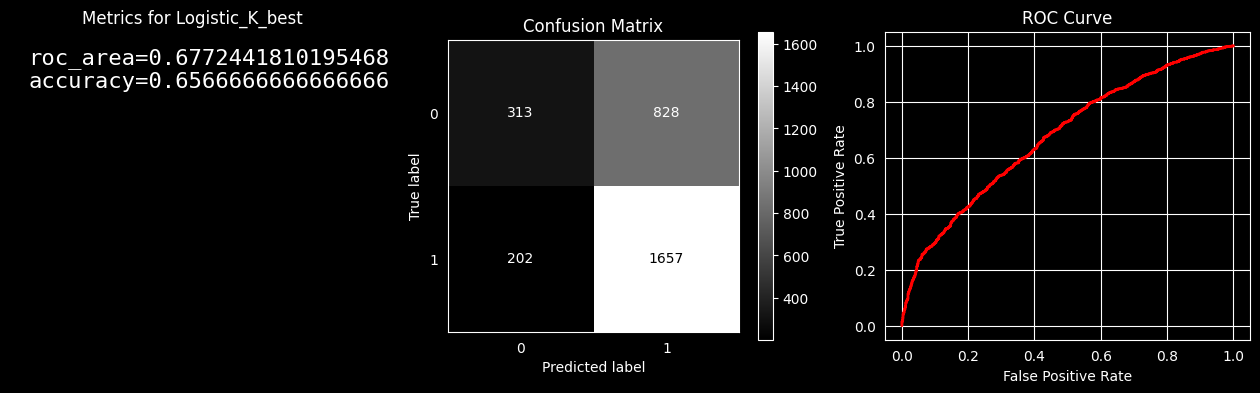

In [25]:
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression

def objective_logistic(trial):
    ## Features Selector
    selector_k = trial.suggest_int('features_selector__k', 1, 9)

    ## Classifier
    C = trial.suggest_float('classifier__C', 1e-3, 1e2, log=True)
    solver = trial.suggest_categorical('classifier__solver', ['lbfgs', 'liblinear', 'saga'])


    pipe = Pipeline([('features_selector', SelectKBest(k=selector_k, score_func=f_classif)) ,
                     ('classifier', LogisticRegression(C=C, solver=solver, max_iter=1000))])
    pipe.fit(x_train, y_train)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(pipe, x_train, y_train, cv=cv, scoring= 'roc_auc').mean()

    return score

logistic_model = optimize_train_and_judge("Logistic_K_best", LogisticRegression, objective_logistic, trials=10)